***Савенкова Марина, гр. 932226***




#Задание

**Многоклассовый классификатор** (вариант чётный)

Оценка здоровья внутриутробного развития плода: https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification Метка класса: fetal_health.

1.	Выполнить загрузку и предварительную обработку данных из наборов.
2.	Разделить каждую выборку на обучающую, тестовую и валидационную.
3.	Произвести обучение набора нейросетевых архитектур, отличающихся разным набором параметров: число слоёв, количество нейронов в слоях, функции активации в слоях, процедур оптимизации: то есть подобрать архитектуры нейронных сетей, которые с одной стороны позволяют получить модели с лучшими метриками качества работы, с другой стороны не являются избыточными и не переобученными.
4.	Вычислить следующие метрики работы:
Для многоклассового классификатора: Recall, Precision, Weighted Accuracy, AUC для всех классов всех исследованных моделей. Вывести ROC-кривые для каждого класса в лучшем классификаторе.


#Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import missingno as msno

In [ ]:
import sklearn as skn

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, roc_curve
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import metrics

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
# подключение диска

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/"

#Функции

In [ ]:
# визуализация процесса обучения

def acc_and_loss_visualization(history, colors):

  clrs = [
      colors[1],
      colors[len(colors) - 1]
    ]

  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(train_loss) + 1)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_acc, label='Training Accuracy', color = clrs[0])
  plt.plot(epochs, val_acc, label='Validation Accuracy', color = clrs[1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_loss, label='Training Loss', color = clrs[0])
  plt.plot(epochs, val_loss, label='Validation Loss', color = clrs[1])
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# построение ROC-кривой

def plot_roc_curve_for_all_classes(model, X_test, y_test, colors):

  y_pred = model.predict(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(10, 6))

  clrs = [
      colors[0],
      colors[len(colors) - 1],
      colors[round((len(colors) - 1) / 2)]
      ]

  for i in range(3):
      #plt.plot(fpr[i], tpr[i], label=f'Class {chr(65 + i)} (AUC = {roc_auc[i]:.2f})', color = clrs[i])
      plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})', color = clrs[i])

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Multi-Class Classification')
  plt.legend(loc='best')
  plt.show()

In [ ]:
# функция для вывода метрик

def print_scores(model, X_test, y_test):

  scores = model.evaluate(X_test, y_test, verbose=0)

  print('Accuracy: ', scores[1])
  print('AUC: ', scores[2])
  print('Precision: ', scores[3])
  print('Recall: ', scores[4])
  print('Weighted Accuracy: ', scores[5])
  print('')

  pred = model.predict(X_test, verbose=0)

  y_pr = pred.argmax(axis=-1)
  y_t = y_test.argmax(axis=-1)

  report = classification_report(y_t, y_pr)
  print(report)

In [ ]:
# визуализация количества в каждом классе
# среди тестовых и предсказанных меток
# на примере круговых диаграмм

def test_and_pred_classes_count_pie(model, X_test, y_test):

  pred = model.predict(X_test, verbose=0)

  y_pr = pred.argmax(axis=-1)
  y_t = y_test.argmax(axis=-1)

  labels = ['Normal', 'Suspect', 'Patological']

  unique, counts = np.unique(y_t, return_counts=True)

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
  ax1.pie(counts, labels = labels, colors = colors, textprops={'fontsize': 14}, autopct='%1.1f%%')
  ax1.set_title("Test")

  unique, counts = np.unique(y_pr, return_counts=True)

  ax2.pie(counts, labels = labels, colors = colors, textprops={'fontsize': 14}, autopct='%1.1f%%')
  ax2.set_title("Predicted")

In [ ]:
# Матрицы спутанности для каждого класса

def confusion_matrix(model, X_test, y_test, palette):

  pred = model.predict(X_test, verbose=0)

  y_pred = pred.argmax(axis=-1)
  y_true = y_test.argmax(axis=-1)

  matrix = multilabel_confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

  class_names = ['Normal', 'Suspect', 'Patological']

  for i in range(0, matrix.shape[0]):

    ax = sns.heatmap(matrix[i], annot=True, cmap=palette)

    ax.set_title(class_names[i]);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    plt.show()


#Описание набора данных

Снижение детской смертности отражено в ряде целей Организации Объединенных Наций в области устойчивого развития и является ключевым показателем прогресса человечества.
ООН ожидает, что к 2030 году страны положат конец предотвратимой смертности новорожденных и детей в возрасте до 5 лет, при этом все страны стремятся снизить смертность детей в возрасте до 5 лет по крайней мере до 25 на 1000 живорождений.

Параллельным понятию детской смертности, конечно же, является материнская смертность, на долю которой приходится 295 000 смертей во время беременности и родов и после них (по состоянию на 2017 год). Подавляющее большинство этих смертей (94%) произошло в условиях нехватки ресурсов, и большинство из них можно было предотвратить.

В свете того, что было упомянуто выше, кардиотокограммы (КТГ) являются простым и доступным по стоимости способом оценки здоровья плода, позволяющим медицинским работникам принимать меры для предотвращения детской и материнской смертности. Само оборудование работает, посылая ультразвуковые импульсы и считывая их реакцию, тем самым проливая свет на частоту сердечных сокращений плода, движения плода, сокращения матки и многое другое.

Этот набор данных содержит 2126 записей признаков, извлеченных из результатов кардиотокограмм, которые затем были классифицированы тремя экспертами-акушерами на 3 класса:




*   Normal (Нормальные)
*   Suspect (Подозрительные)
*   Pathological (Патологические)





Набор данных содержит следующие признаки:


  * baseline_value - исходная частота сердечных сокращений плода;
  * accelerations - количество ускорений в секунду
  * fetal_movement - количество движений плода в секунду
  * uterine_contractions - количество сокращений матки в секунду
  * light_decelerations - количество LDS в секунду
  * severe_deceleration -  количество Sds в секунду
  * prolongued_deceleration - количество PDs в секунду
  * abnormal_short_term_variatability - процент времени с ненормально коротким периодом изменчивости
  * mean_value_of_short_term_variability - среднее значение краткосрочной изменчивости
  * percentage_of_time_with_abnormal_long_term_variability - Процент времени с аномальной долгосрочной изменчивостью
  * mean_value_of_long_term_variability - среднее значение длительной вариабельности
  * histogram_width - Ширина гистограммы с использованием всех значений из записи
  * histogram_min - минимальное значение гистограммы
  * histogram_max - максимальное значение гистограммы
  * histogram_number_of_peaks - количество пиков в гистограмме
  * histogram_number_of_zeroes - количество нулей в гистограмме
  * histogram_mode - режим гистограммы
  * histogram_mean - среднее значение гистограммы
  * histogram_median - медиана гистограммы
  * histogram_variance - дисперсия гистограммы
  * histogram_tendency - тенденция гистограммы
  * fetal_health - здоровье плода


#Загрузка набора данных

In [ ]:
df = pd.read_csv(path + 'fetal_health.csv')

df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


#Анализ и предварительная обработка данных

In [ ]:
# настройка параметров отображения графиков
#plt.rcParams.update({'axes.facecolor':'#f5f5f5'})
#plt.rcParams['axes.facecolor'] = '#DBD7D2'
#plt.rcParams['axes.facecolor'] = 'ede9e4'
#plt.rcParams['axes.facecolor'] = 'd7d1e0'
#plt.rcParams['axes.facecolor'] = 'e3ddeb'
#plt.rcParams['axes.facecolor'] = 'e9e4f0'
plt.rcParams['axes.facecolor'] = 'ddd8e3'

# цвета
palette = 'BrBG'

colors = [
    '#864d09',
    '#b57726',
    '#d5ae65',
    '#eddaaa',
    '#f5efde',
    '#e0f0ed',
    '#addfd8',
    '#69bdb2',
    '#2a8d85',
    '#006159'
  ]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

##Проверка пропущенных значений

<Axes: >

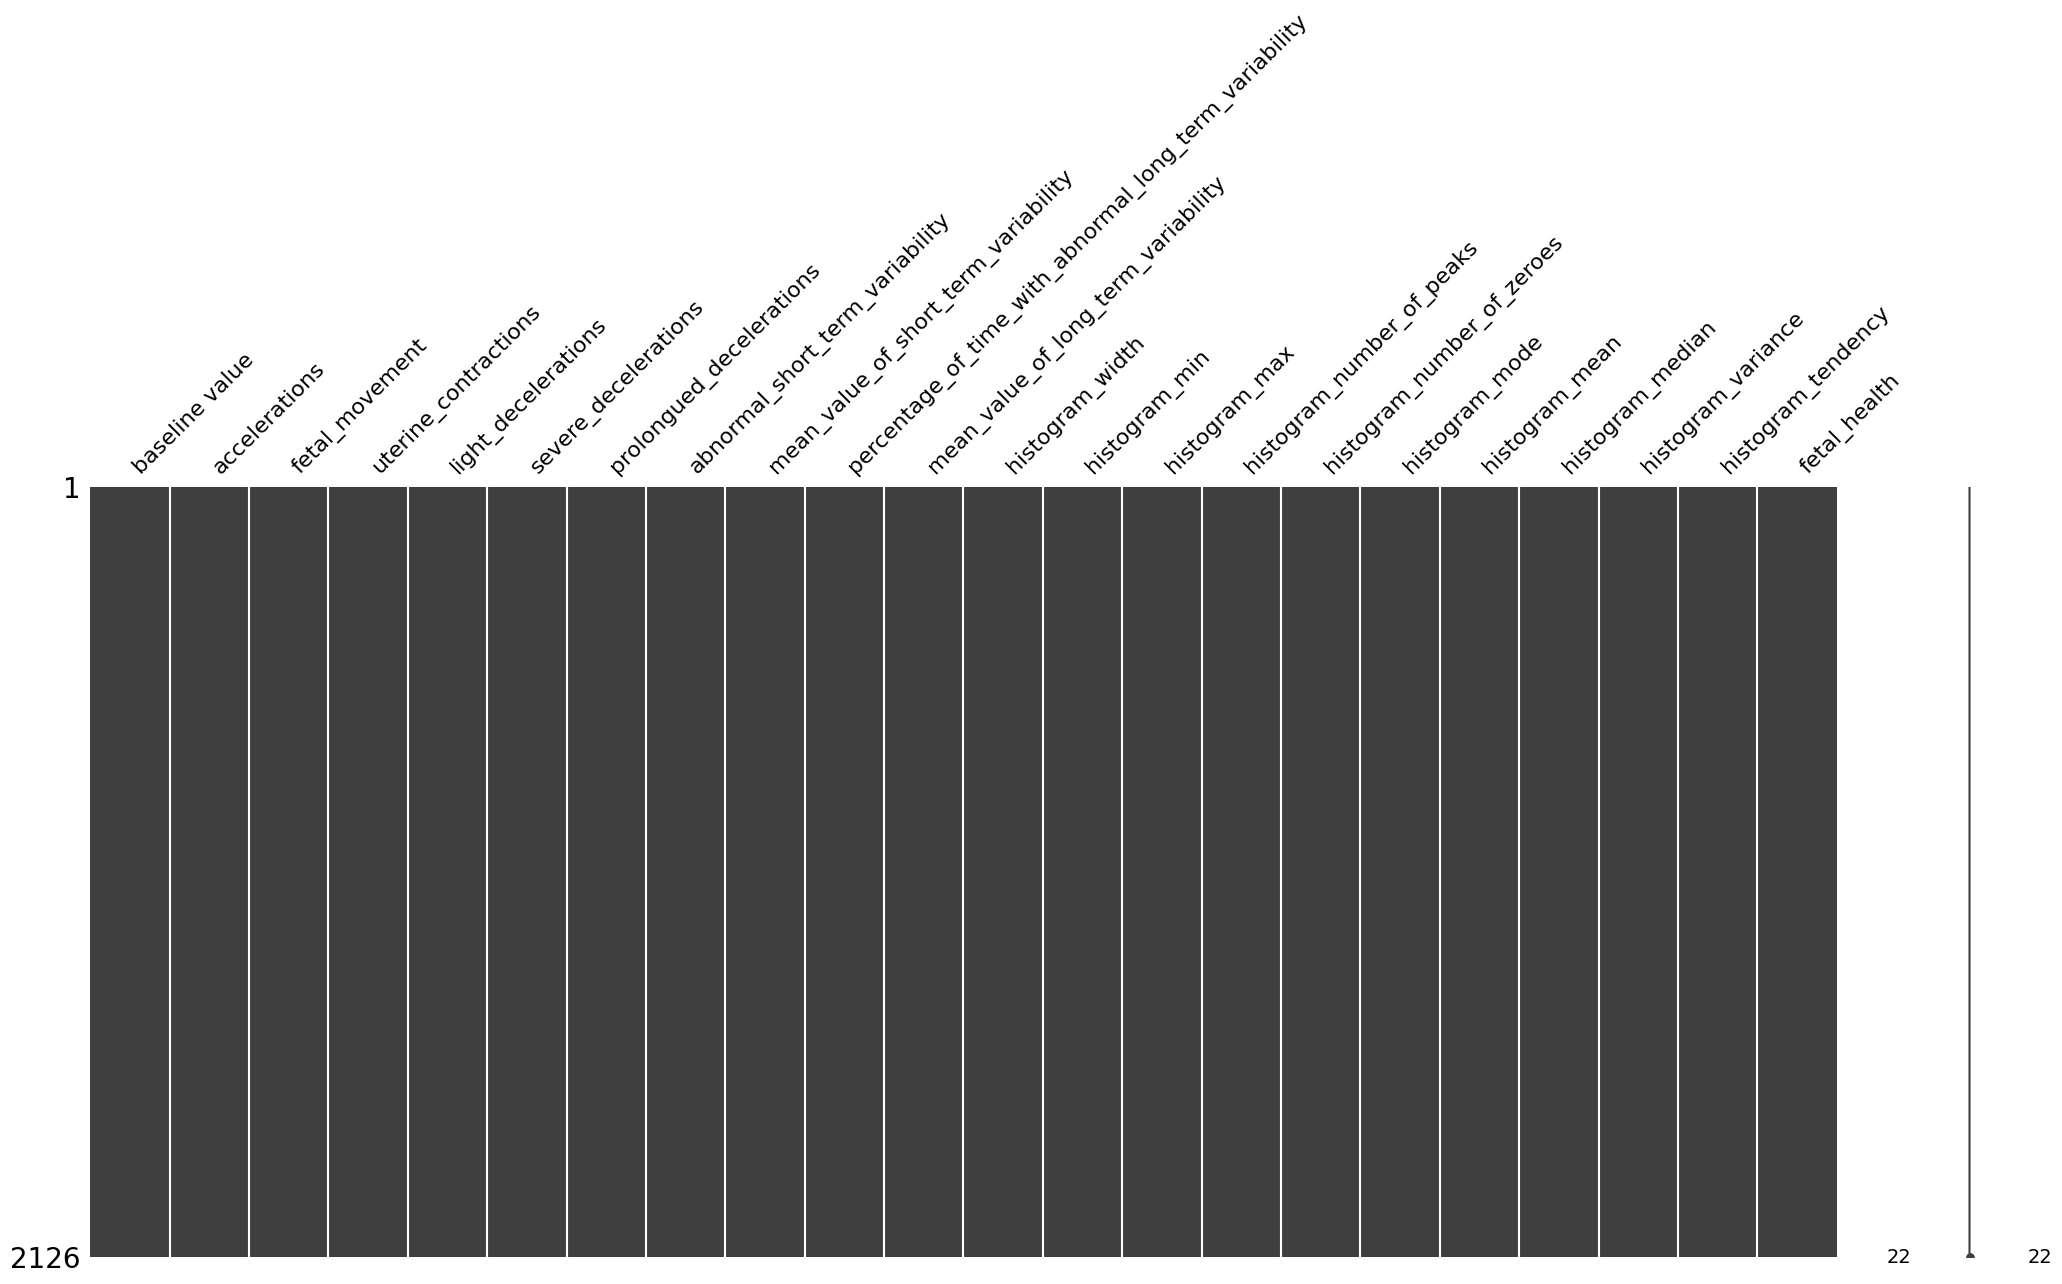

In [ ]:
msno.matrix(df)

##Проверка датасета на сбалансированность

Выведем количественное соотношение значений целевой переменной.

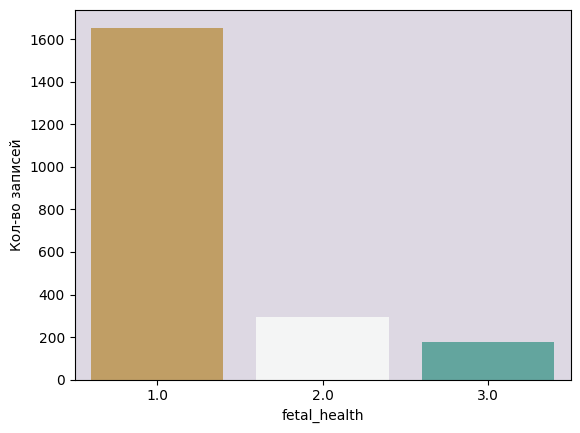

In [ ]:
#sns.set_style('white')
sns.countplot(x='fetal_health',data=df,palette=palette)
plt.xlabel('fetal_health')
plt.ylabel('Кол-во записей')
plt.show()

Из графика видно несбалансированность датасета.

##Описательная статистика

Выведем описательную статистику.

In [ ]:
pd.set_option('display.max_columns', 30)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


##Матрица корреляции

Построим матрицу корреляции для признаков.

In [1]:
mask = np.triu(np.ones_like(df.corr()))

plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=True, fmt='.2f',  cmap='BrBG', mask=mask)

NameError: ignored


По матрице корреляции можно заключить, что признаки accelerations, prolongued_decelerations, abnormal_short_term_variability, percentage_of_time_with_abnormal_long_term_variability and mean_value_of_long_term_variability наиболее сильно связаны с целевой переменной fetal_health.

Рассмотрим зависимость этих признаков.

##Зависимость accelerations (ускорения) и движения плода (fetal_movement)
  

<Axes: xlabel='accelerations', ylabel='fetal_movement'>

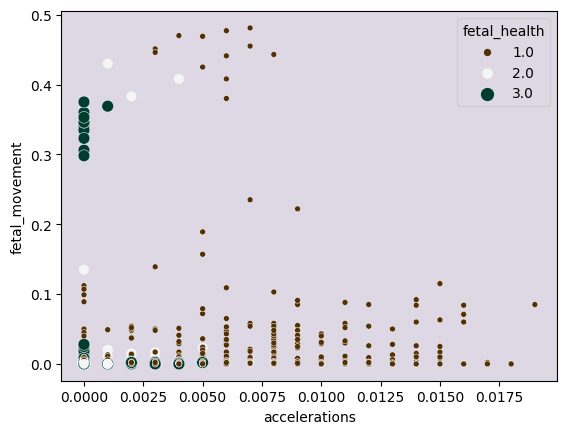

In [ ]:
sns.scatterplot(
    data=df,
    x="accelerations",
    y="fetal_movement",
    hue="fetal_health",
    size="fetal_health",
    palette = palette
  )

Патологические и подозрительные значения располагаются близко к нулю по оси абсцисс.

<ipython-input-23-e6f0a43db10e>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


<Axes: xlabel='fetal_health', ylabel='accelerations'>

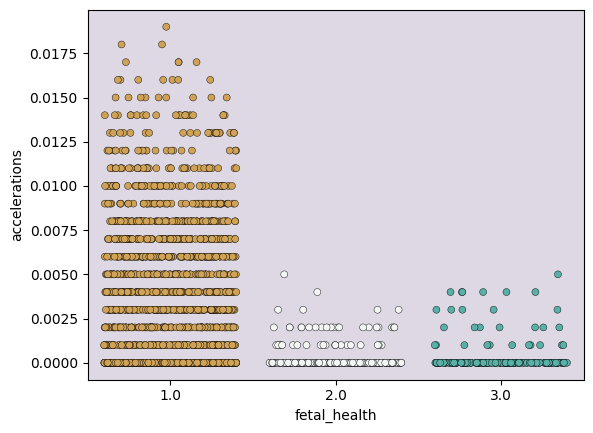

In [ ]:
sns.stripplot(
    x="fetal_health",
    y="accelerations",
    data=df,
    palette = palette,
    jitter = .4,
    edgecolor='k',
    linewidth=.3
  )

Чем меньше значение accelerations, тем более вероятно, что значения подозрительные или патологические.

##Зависимость prolonged decelerations (длительное замедление) и fetal movement (движение плода)
  

<Axes: xlabel='prolongued_decelerations', ylabel='fetal_movement'>

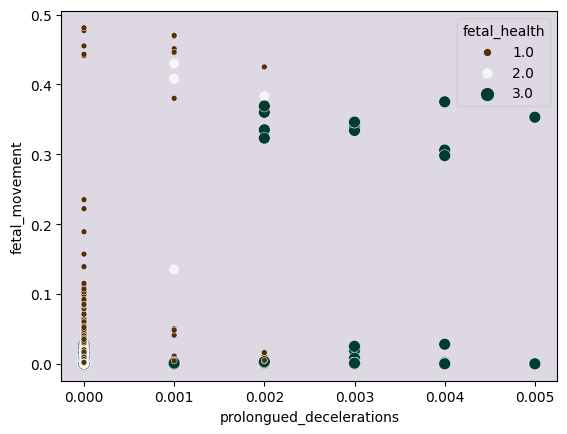

In [ ]:
sns.scatterplot(
    data=df,
    x="prolongued_decelerations",
    y="fetal_movement",
    hue="fetal_health",
    size="fetal_health",
    palette = palette
  )

<ipython-input-25-a301744f0744>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


<Axes: xlabel='fetal_health', ylabel='prolongued_decelerations'>

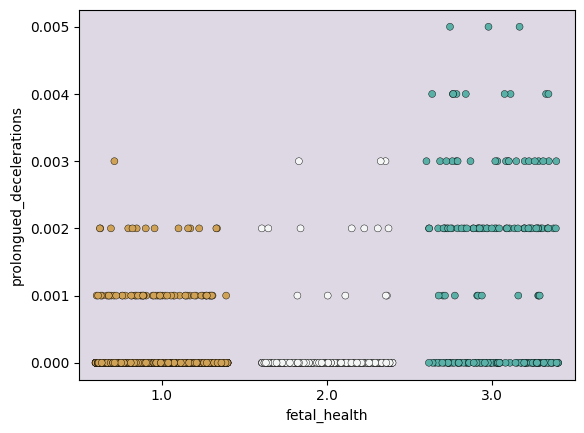

In [ ]:
sns.stripplot(
    x="fetal_health",
    y="prolongued_decelerations",
    data=df,
    palette = palette,
    jitter = .4,
    edgecolor='k',
    linewidth=.3
  )

Соответственно, в случае признака prolonged decelerations имеется обратная тенденция.

<ipython-input-26-aef10e75ca5f>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


<Axes: xlabel='fetal_health', ylabel='fetal_movement'>

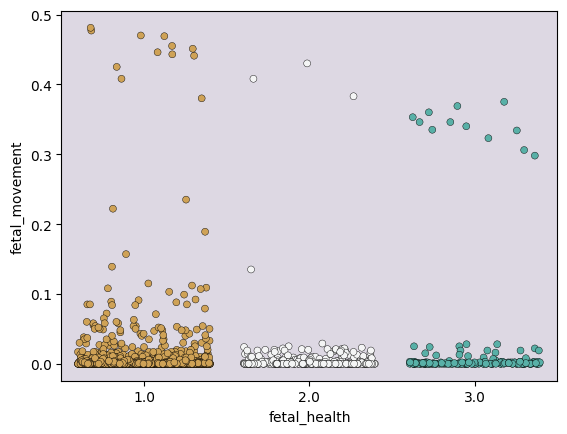

In [ ]:
sns.stripplot(
    x="fetal_health",
    y="fetal_movement",
    data=df,
    palette = palette,
    jitter = .4,
    edgecolor='k',
    linewidth=.3
  )

##Зависимость abnormal short term variability (аномальная кратковременная изменчивость) и fetal movement (движение плода)

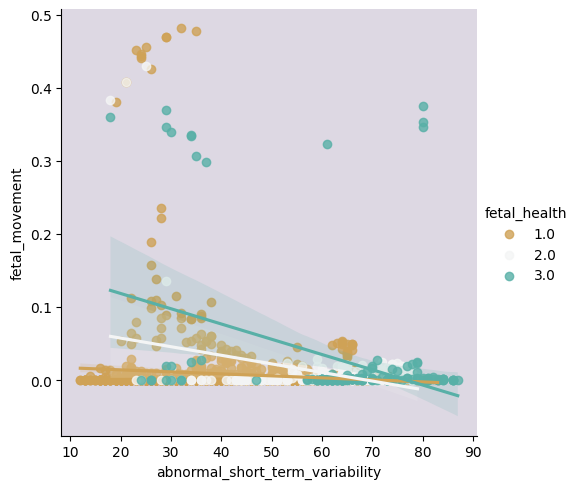

In [ ]:
sns.lmplot(
    data=df,
    x="abnormal_short_term_variability",
    y="fetal_movement",palette=palette,
    hue="fetal_health"
  )

<ipython-input-28-1b04a338aea9>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


<Axes: xlabel='fetal_health', ylabel='abnormal_short_term_variability'>

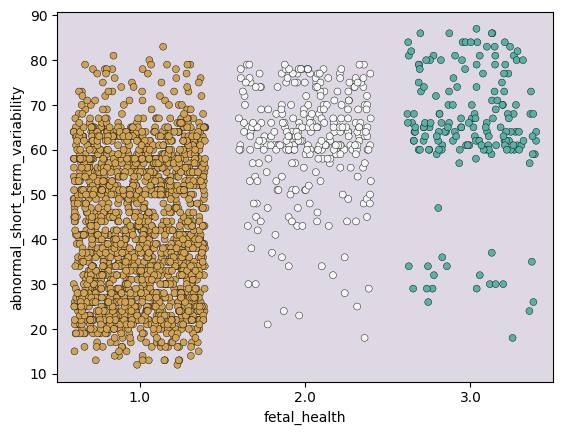

In [ ]:
sns.stripplot(
    x="fetal_health",
    y="abnormal_short_term_variability",
    data=df,
    palette = palette,
    jitter = .4,
    edgecolor='k',
    linewidth=.3
  )

##Зависимость mean value of long term variability (среднее значение долгосрочной изменчивости) от fetal movement (движение плода)


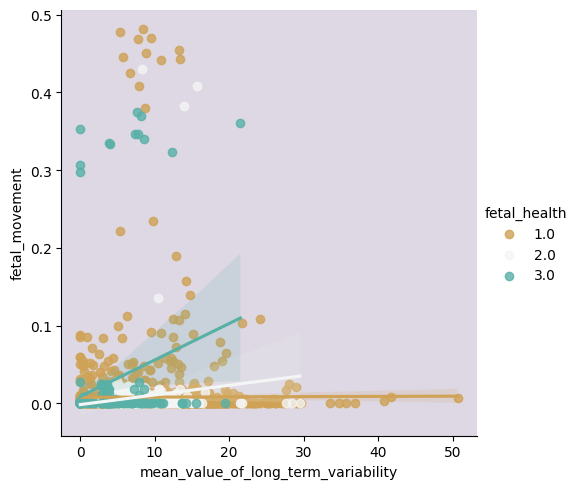

In [ ]:
sns.lmplot(
    data=df,
    x="mean_value_of_long_term_variability",
    y="fetal_movement",
    palette=palette,
    hue="fetal_health"
  )

<ipython-input-30-0a4c330b2f58>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


<Axes: xlabel='fetal_health', ylabel='mean_value_of_long_term_variability'>

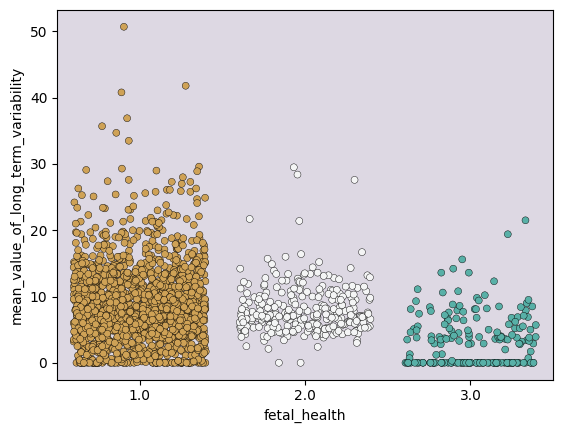

In [ ]:
sns.stripplot(
    x="fetal_health",
    y="mean_value_of_long_term_variability",
    data=df,
    palette = palette,
    jitter = .4,
    edgecolor='k',
    linewidth=.3
  )

Как мы видим из графиков, изменение каждого из рассмотренных выше признаков определенным образом влияет на целевую переменную.

##Проверка выбросов

На графиках выше также можно было отметить выбросы. Рассмотрим их детальнее.

In [ ]:
colnames = list(df.columns)
colnames.pop()
colnames

['baseline value',
 'accelerations',
 'fetal_movement',
 'uterine_contractions',
 'light_decelerations',
 'severe_decelerations',
 'prolongued_decelerations',
 'abnormal_short_term_variability',
 'mean_value_of_short_term_variability',
 'percentage_of_time_with_abnormal_long_term_variability',
 'mean_value_of_long_term_variability',
 'histogram_width',
 'histogram_min',
 'histogram_max',
 'histogram_number_of_peaks',
 'histogram_number_of_zeroes',
 'histogram_mode',
 'histogram_mean',
 'histogram_median',
 'histogram_variance',
 'histogram_tendency']

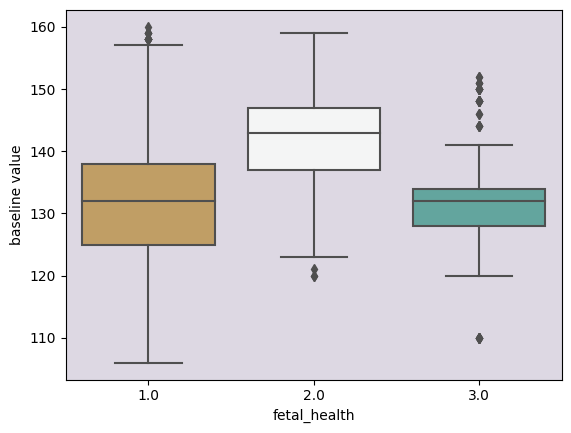

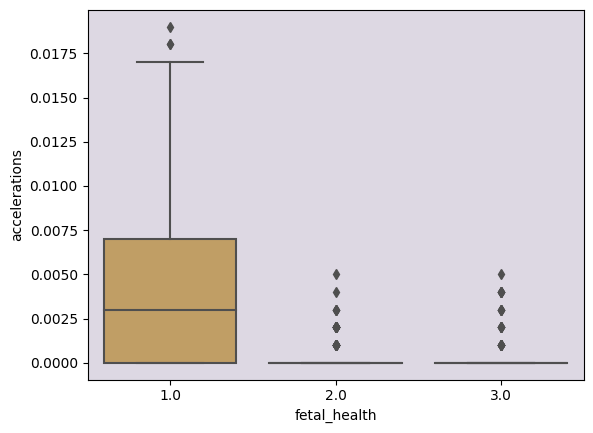

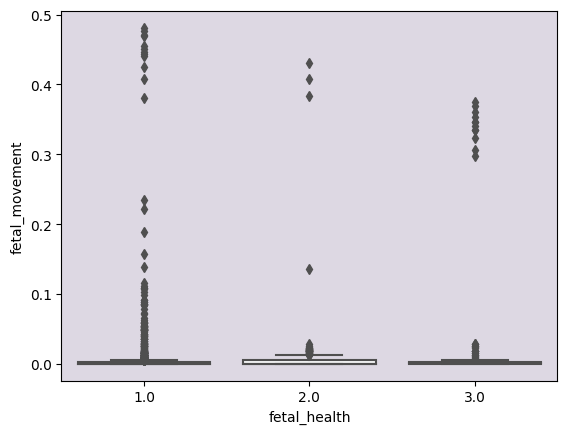

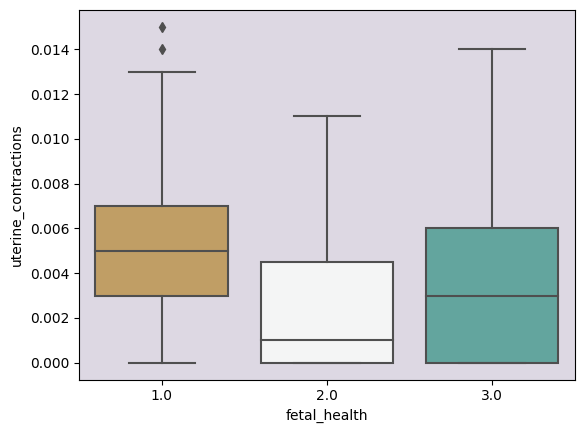

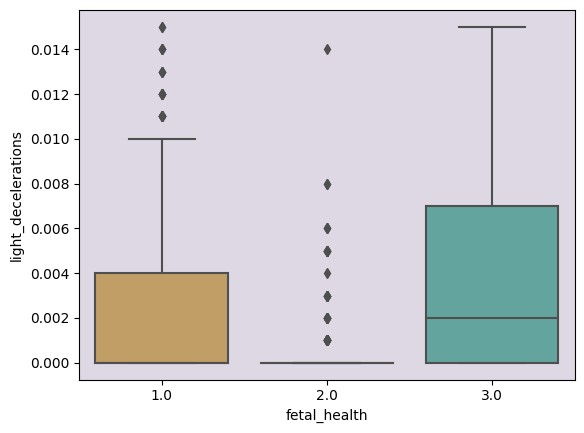

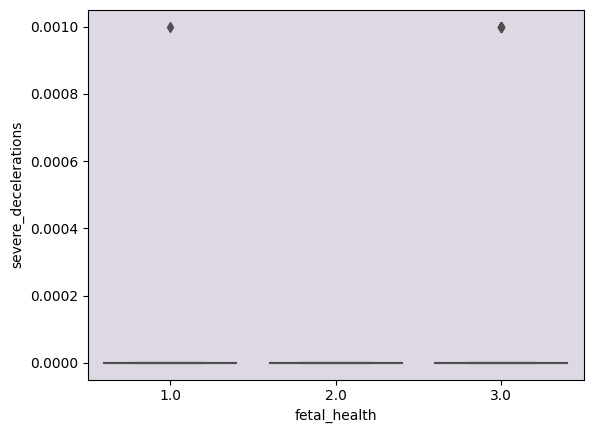

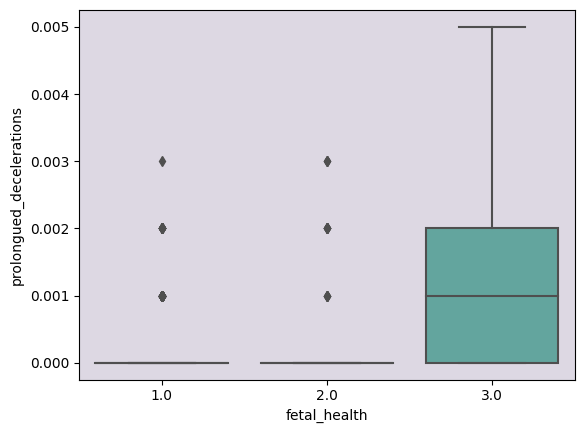

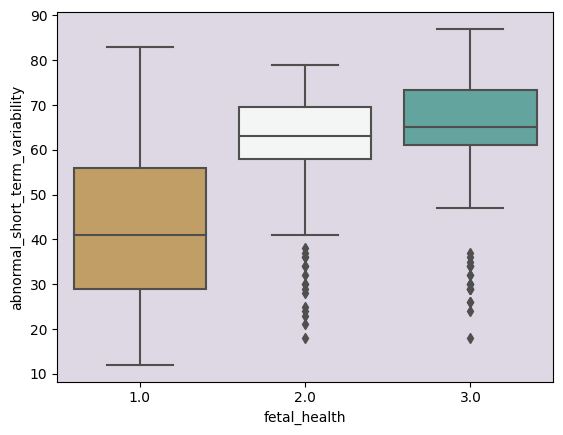

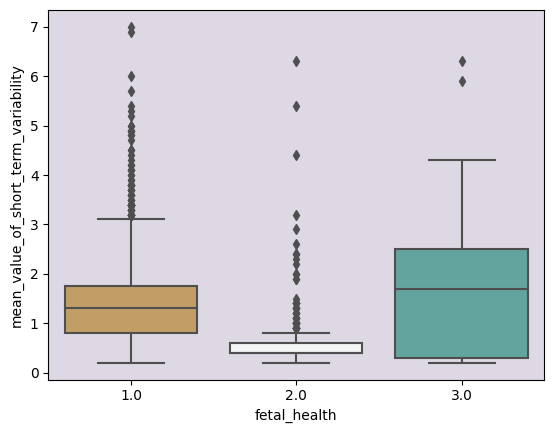

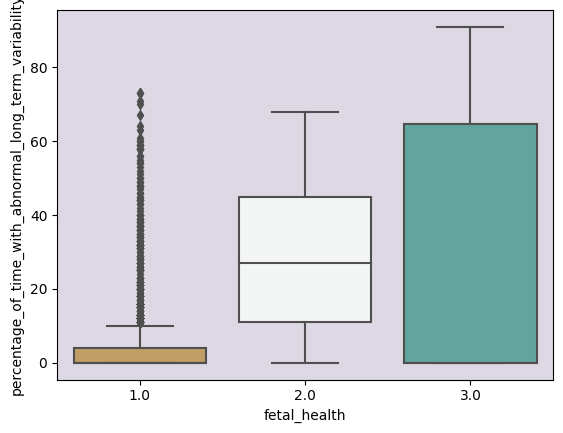

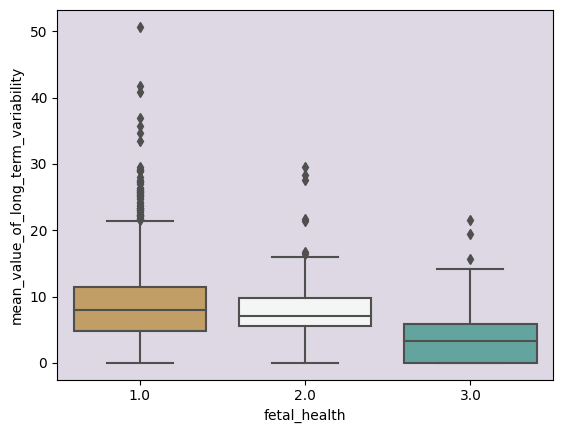

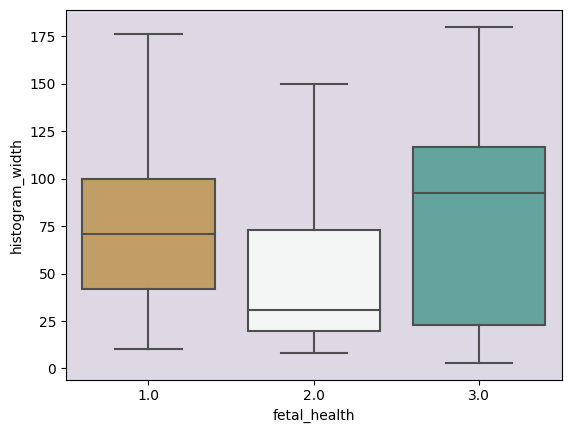

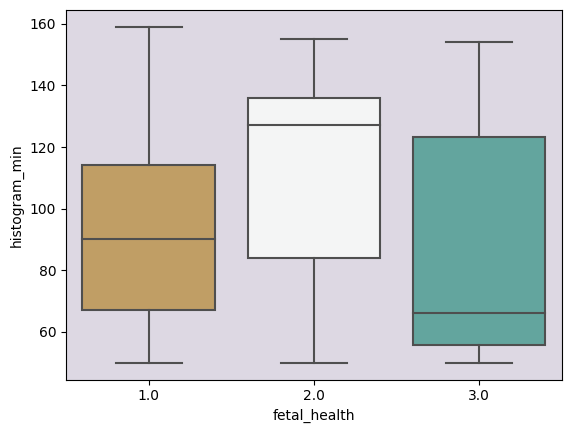

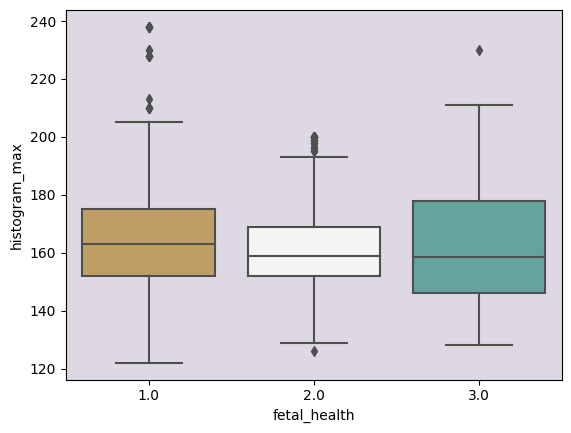

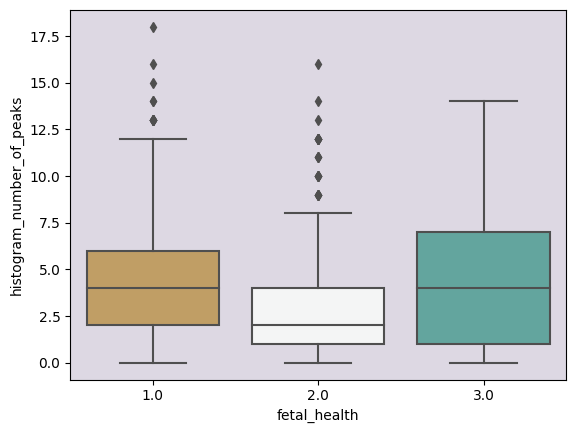

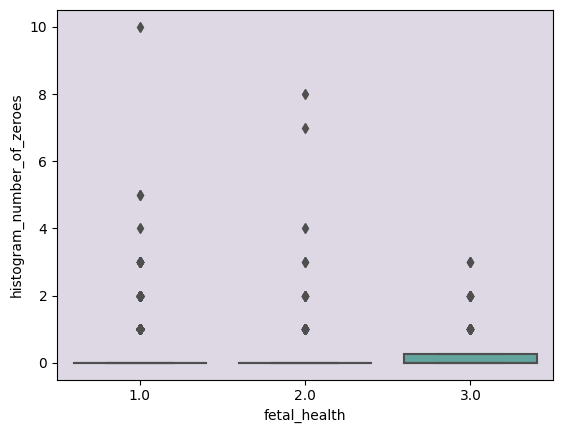

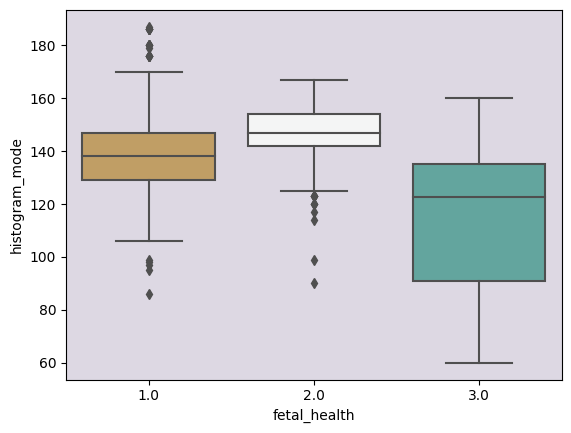

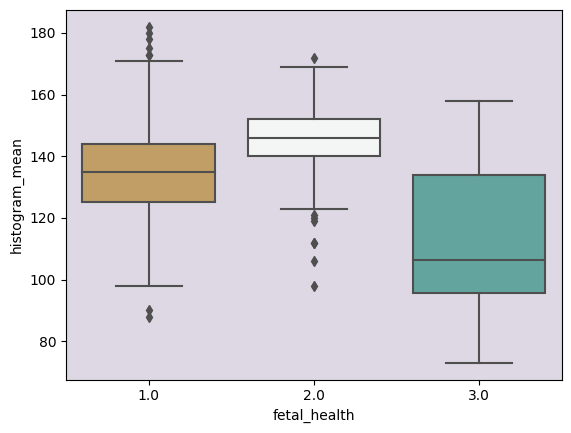

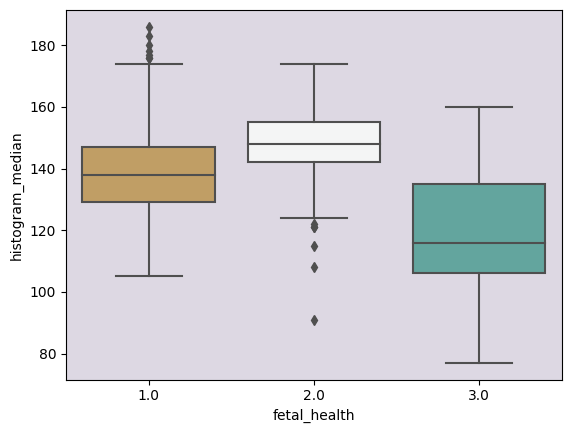

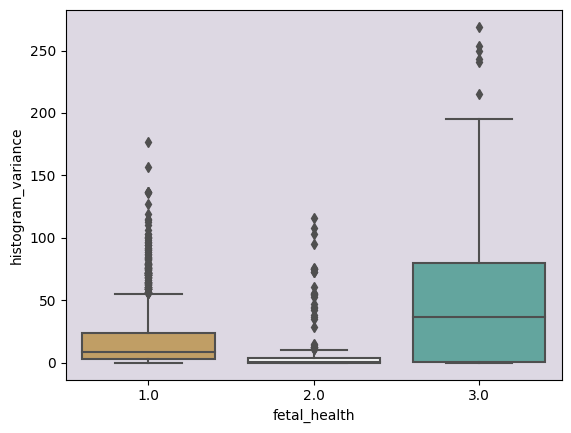

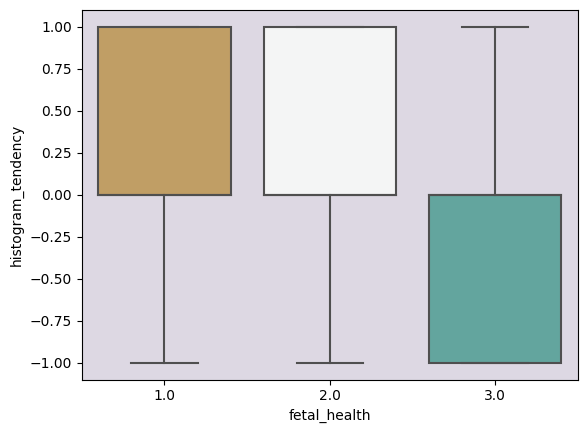

In [ ]:
for i in colnames :
    #sns.boxenplot(x=df["fetal_health"], y=df[i], palette=palette)
    sns.boxplot(x=df["fetal_health"], y=df[i], palette=palette)
    plt.show()

Поскольку мы рассматриваем задачу классификации разделения данных на нормальные, подозрительные и патологические, удаление выбросов может значительно снизить качество модели. Метки были присвоены экспертами, поэтому удалять выбросы в данной задаче, вероятно, скажется негативно на процессе обучения.

#Разделение данных на выборки

In [ ]:
total_number_of_classes = 3

##Oversampling

Осуществим балансировку датасета.

In [ ]:
fhealth = df.copy()

In [ ]:
# уникальные значения целевой переменной

fhealth['fetal_health'].unique()

array([2., 1., 3.])

In [ ]:
# разделение датасета на несколько в зависимости от значения fetal_health

df_Normal = fhealth[fhealth['fetal_health'] == 1]
df_Suspect = fhealth[fhealth['fetal_health'] == 2]
df_Pathological = fhealth[fhealth['fetal_health'] == 3]

print(len(df_Normal))
print(len(df_Suspect))
print(len(df_Pathological))

1655
295
176


In [ ]:
# сделаем выборки из датасета с подозрительными и патологическими метками

df_Suspect_oversample = df_Suspect.sample(len(df_Normal), replace = True, random_state=0)
df_Pathological_oversample = df_Pathological.sample(len(df_Normal), replace = True, random_state=0)

In [ ]:
df_balanced = pd.concat([df_Suspect_oversample, df_Pathological_oversample, df_Normal], axis=0)

In [ ]:
# вычтем единицу из всех значений fetal_health
# (потому что keras ожидает, что классы будут нумероваться с нуля)

fhealth = df_balanced.copy()

In [ ]:
fhealth['fetal_health'] = (fhealth['fetal_health'] - 1).astype(int)
fhealth['fetal_health'].unique()

array([1, 2, 0])

In [ ]:
fhealth_features = fhealth.drop("fetal_health", axis = 1)
fhealth_target = fhealth['fetal_health']

##Стандартизация данных

Приведенный ниже график показывает диапазон значений признаков. Все объекты находятся в разных диапазонах, поэтому необходимо их стандартизировать.

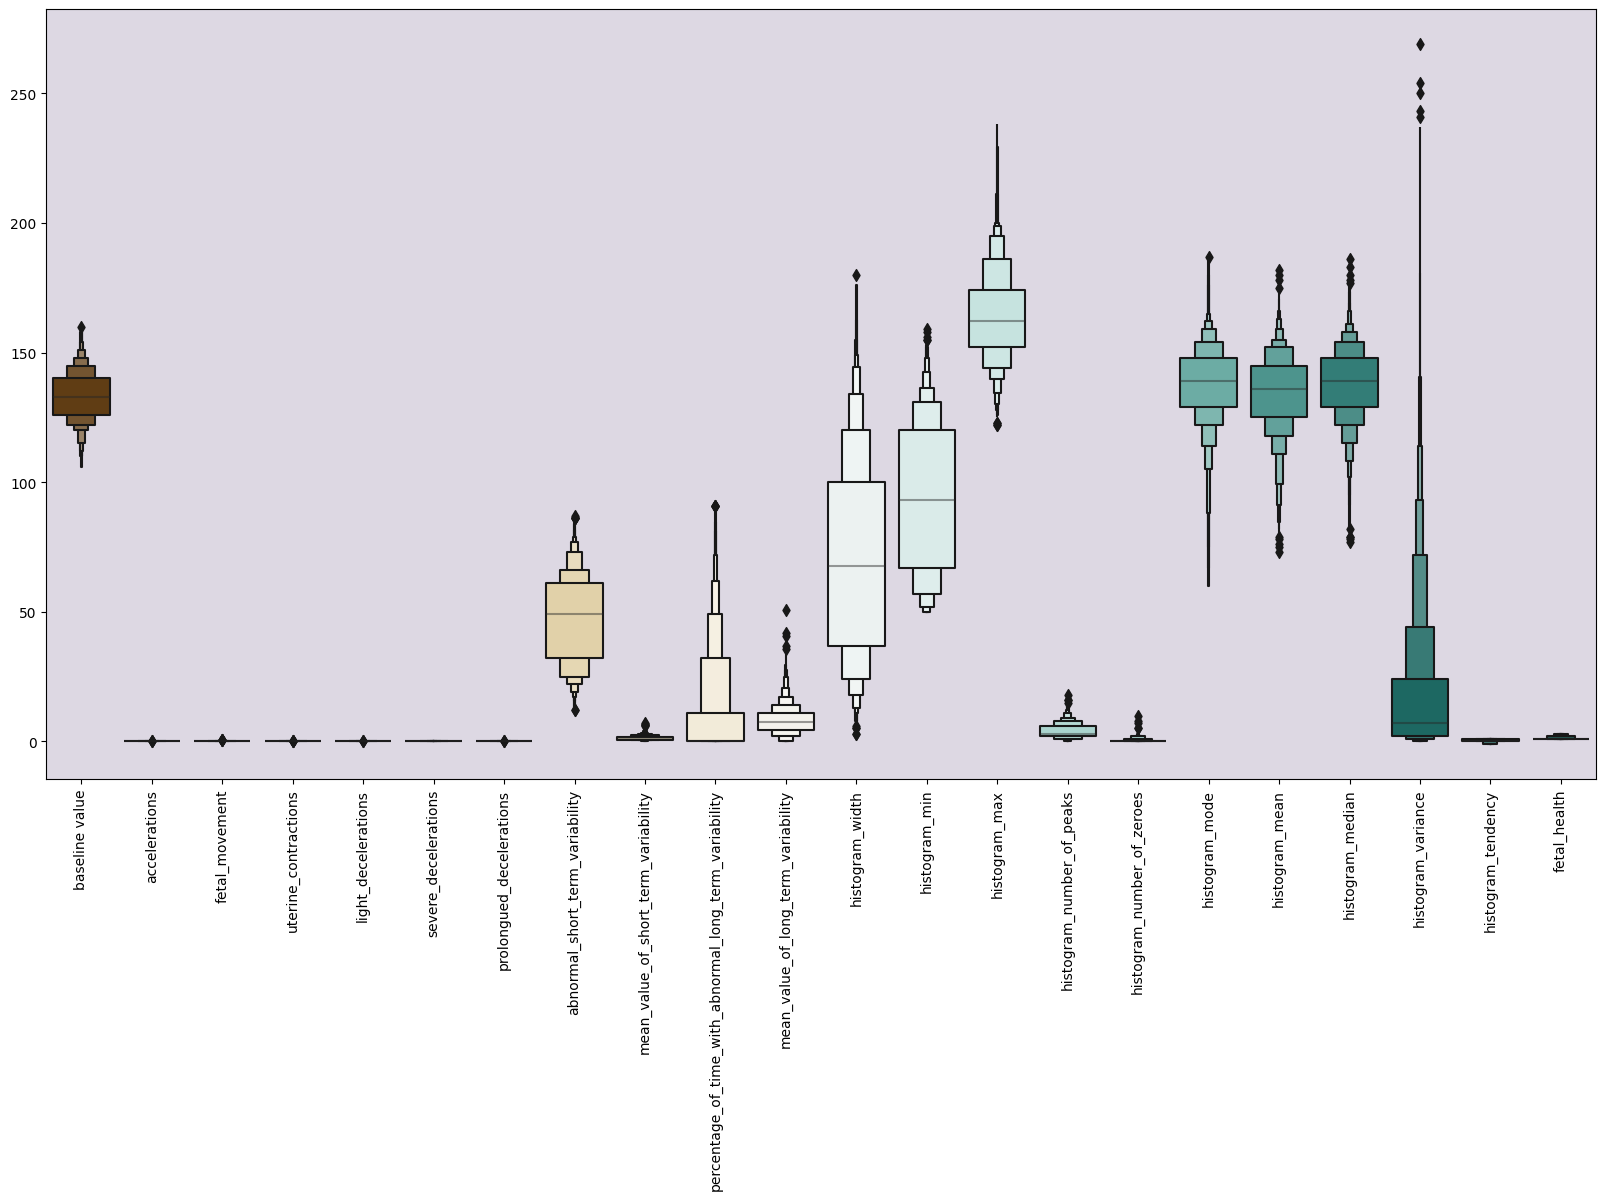

In [ ]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = df,palette = palette)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# стандартизация данных

st_scaler = StandardScaler()
fhealth_features = st_scaler.fit_transform(fhealth_features)

Построим график распредения значений признаков после стандартизации.

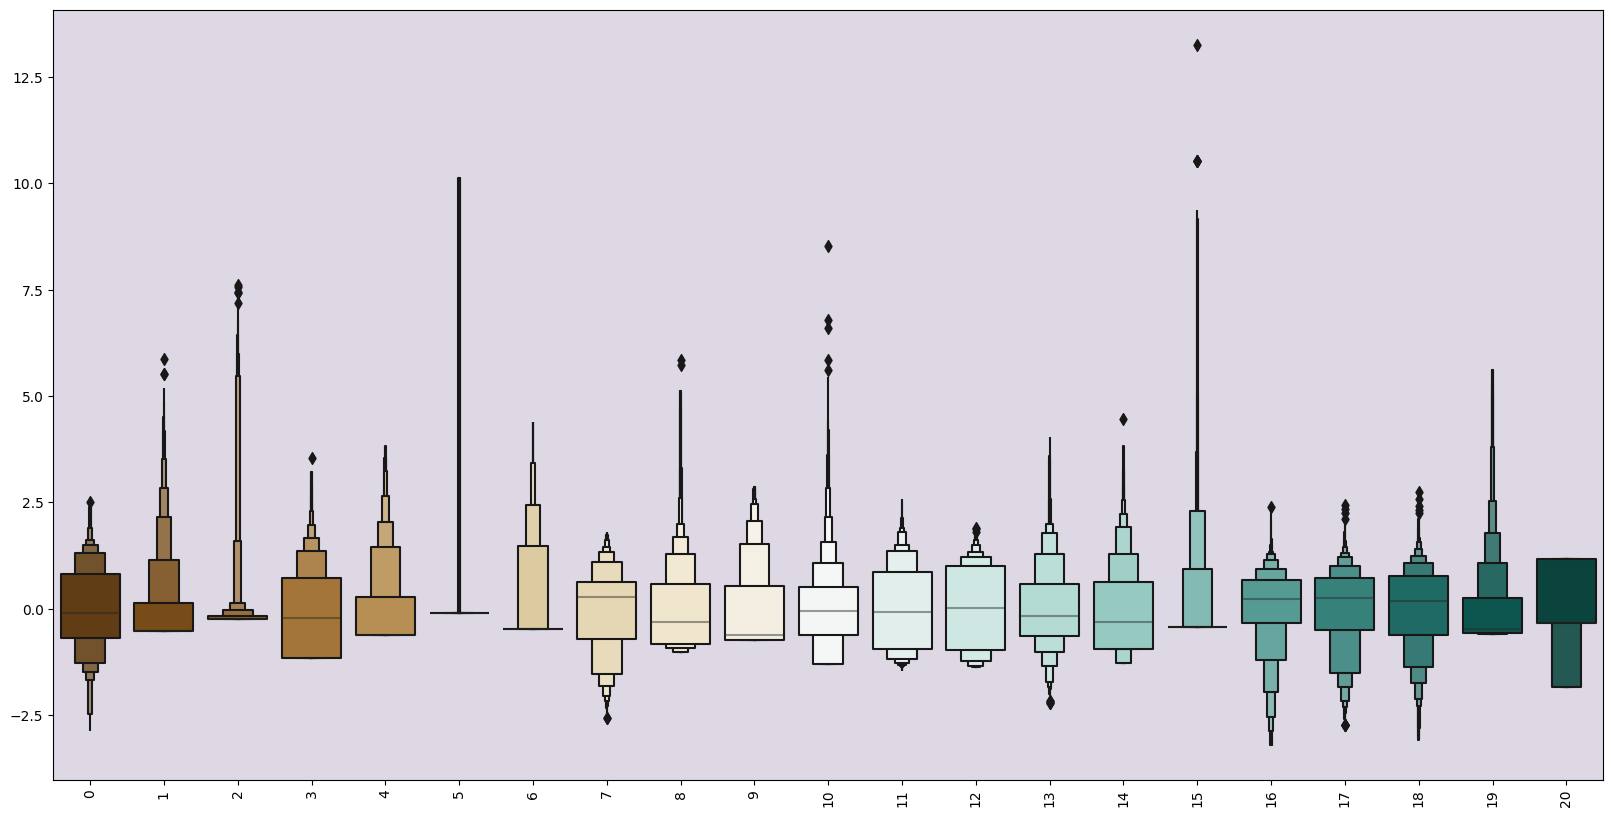

In [ ]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = fhealth_features,palette = palette)
plt.xticks(rotation=90)
plt.show()

##Разделение на выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  fhealth_features,
  fhealth_target,
  train_size=0.7,
  random_state=0,
  stratify=fhealth_target
)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(
  X_test, y_test,
  train_size=0.5,
  random_state=0,
  stratify=y_test
)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train , num_classes=total_number_of_classes)
y_train

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
y_val = tf.keras.utils.to_categorical(y_val , num_classes=total_number_of_classes)
y_val

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=total_number_of_classes)
y_test

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

#Наборы нейросетевых архитектур

##Модель №1

Построим модель с тремя слоями: 64, 32 и 3 нейрона (по числу классов). Функция активации выходного слоя softmax, остальных слоев - relu.

In [ ]:
model_1 = Sequential()

model_1.add(tf.keras.layers.Dense(64, activation='relu'))
model_1.add(tf.keras.layers.Dense(32, activation='relu'))
model_1.add(tf.keras.layers.Dense(total_number_of_classes, activation = 'softmax'))

###Настройка параметров обучения

В качестве оптимизатора был выбран adam как наиболее эффективный алгоритм оптимизации, сочетающий в себе идеи RMSProp и оптимизатора импульса. В качестве функции потерь выбрана categorical_crossentropy. categorical_cross_entropy создает одномерный массив, содержащий вероятное совпадение для каждой категории.

In [ ]:
model_1.compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = [
      metrics.CategoricalAccuracy(),
      metrics.AUC(),
      metrics.Precision(),
      metrics.Recall()
    ],
  weighted_metrics = ['accuracy']
)

Добавим несколько callback-функций:

* early_stop - ранняя остановка;

* checkpoint - функция для сохранения лучшей модели в файл.

In [ ]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 10,
  mode = 'max',
  verbose = 1
)

checkpoint_filepath_1 = path + 'task2/' + 'MC№1.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_1,
  monitor = 'val_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint
  ]

###Обучение модели

Запустим обучение модели на 90 эпохах.

In [ ]:
model_1_history = model_1.fit(
  X_train,
  y_train,
  batch_size=10,
  validation_data=(X_val,y_val),
  callbacks=callbacks_list,
  epochs=90
)

Epoch 1/90
345/348 [============================>.] - ETA: 0s - loss: 0.4647 - categorical_accuracy: 0.8171 - auc: 0.9469 - precision: 0.8605 - recall: 0.7632 - accuracy: 0.8171
Epoch 1: val_accuracy improved from -inf to 0.88859, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task2/MC№1.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


348/348 [==============================] - 3s 5ms/step - loss: 0.4656 - categorical_accuracy: 0.8170 - auc: 0.9465 - precision: 0.8602 - recall: 0.7635 - accuracy: 0.8170 - val_loss: 0.2973 - val_categorical_accuracy: 0.8886 - val_auc: 0.9770 - val_precision: 0.8957 - val_recall: 0.8765 - val_accuracy: 0.8886
Epoch 2/90
334/348 [===========================>..] - ETA: 0s - loss: 0.2876 - categorical_accuracy: 0.8925 - auc: 0.9778 - precision: 0.9016 - recall: 0.8829 - accuracy: 0.8925
Epoch 2: val_accuracy improved from 0.88859 to 0.90872, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task2/MC№1.hdf5
348/348 [==============================] - 1s 3ms/step - loss: 0.2851 - categorical_accuracy: 0.8938 - auc: 0.9782 - precision: 0.9028 - recall: 0.8846 - accuracy: 0.8938 - val_loss: 0.2271 - val_categorical_accuracy: 0.9087 - val_auc: 0.9876 - val_precision: 0.9161 - val_recall: 0.9087 - val_accuracy: 0.9087
Epoch 3/90
338/348 [==============

###Оценка модели

Выведем метрики.

In [ ]:
print_scores(model_1, X_test, y_test)

Accuracy:  0.9771811962127686
AUC:  0.9955785870552063
Precision:  0.9771811962127686
Recall:  0.9771811962127686
Weighted Accuracy:  0.9771811962127686

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       248
           1       0.95      0.98      0.97       249
           2       1.00      1.00      1.00       248

    accuracy                           0.98       745
   macro avg       0.98      0.98      0.98       745
weighted avg       0.98      0.98      0.98       745



Визуализируем процесс обучения.

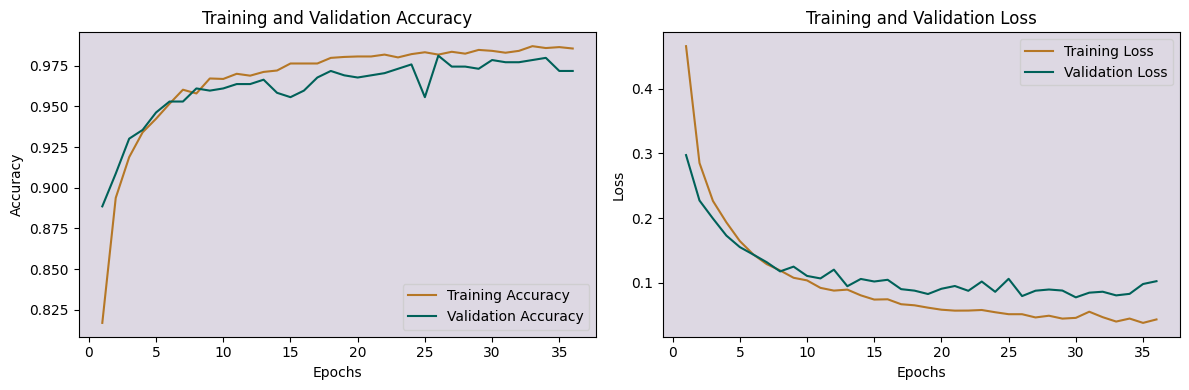

In [ ]:
acc_and_loss_visualization(model_1_history, colors)

Построим ROC-кривые для каждого класса.

24/24 [==============================] - 0s 2ms/step


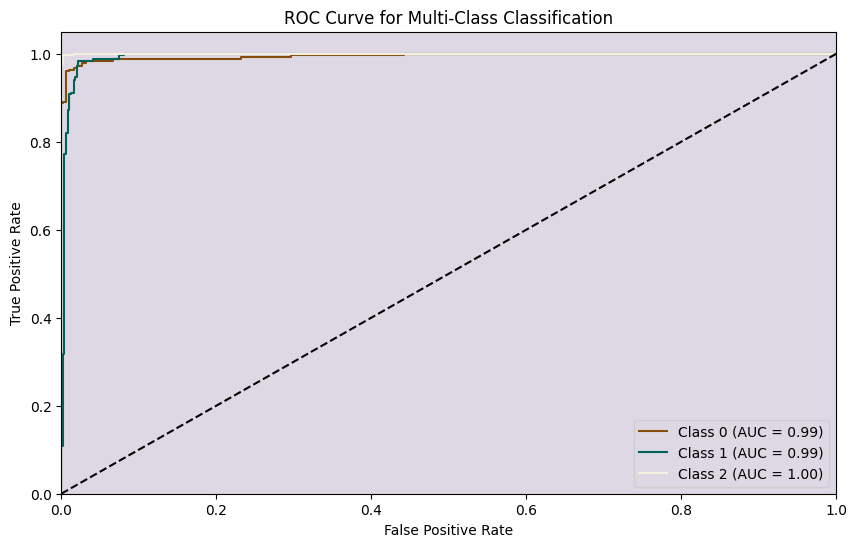

In [ ]:
plot_roc_curve_for_all_classes(model_1, X_test, y_test, colors)

Выведем диаграмму количественного соотношения классов в тестовой выборке и массиве предсказанных значений.

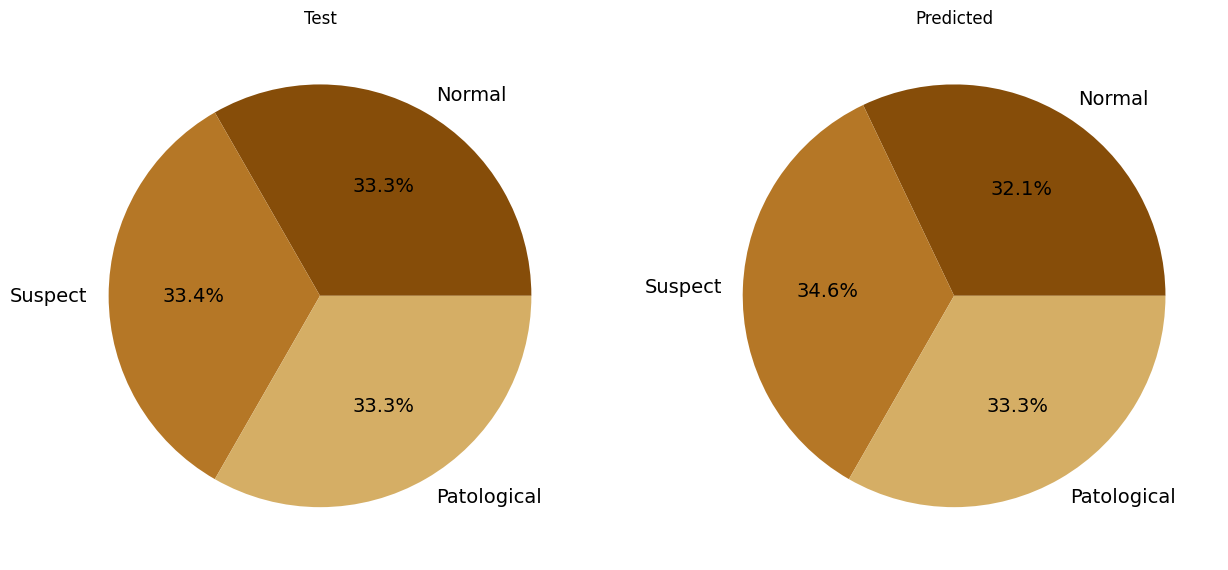

In [ ]:
test_and_pred_classes_count_pie(model_1, X_test, y_test)

И матрицу спутанности для каждого класса.

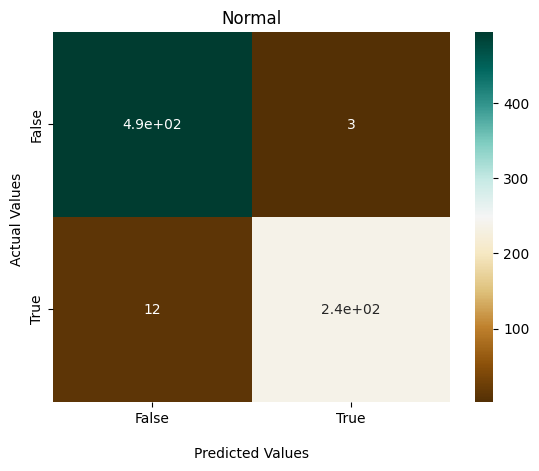

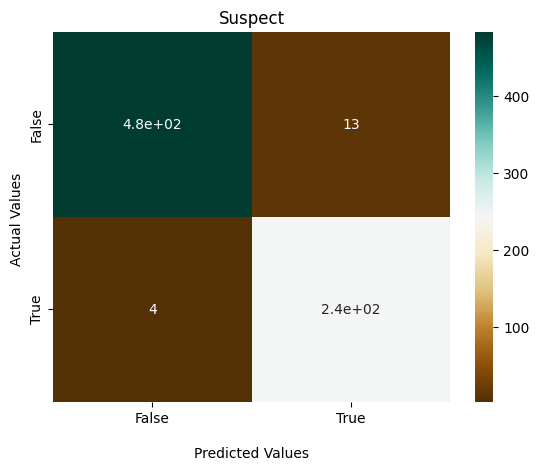

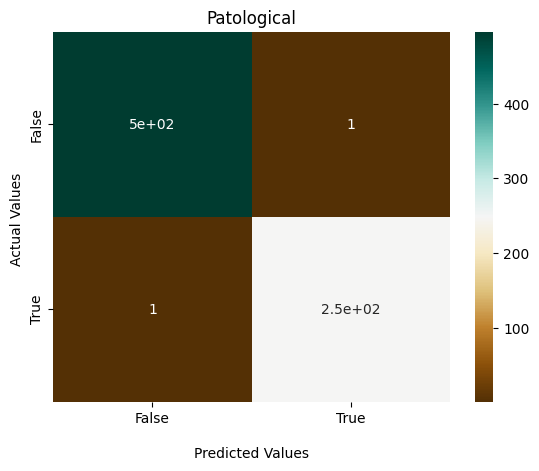

In [ ]:
confusion_matrix(model_1, X_test, y_test, palette)

##Модель №2

Построим модель с двумя полносвязными слоями. Первый слой содержит три нейрона, второй также три (по числу классов). Функция активации первого слоя - relu, выходного - softmax.

In [ ]:
model_2 = Sequential()

model_2.add(tf.keras.layers.Dense(3, activation='relu'))
model_2.add(tf.keras.layers.Dense(total_number_of_classes, activation = 'softmax'))

###Настройка параметров обучения

В качестве оптимизатора на этот раз выберем RMSprop.

In [ ]:
model_2.compile(
  optimizer = "RMSprop",
  loss = "categorical_crossentropy",
  metrics = [
      metrics.CategoricalAccuracy(),
      metrics.AUC(),
      metrics.Precision(),
      metrics.Recall()
    ],
  weighted_metrics = ['accuracy']
)

callback-функции оставим прежними, изменился только путь.

In [ ]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 10,
  mode = 'max',
  verbose = 1
)

checkpoint_filepath_2 = path + 'task2/' + 'MC№2.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_2,
  monitor = 'val_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint
  ]

###Обучение модели

Запустим обучение на 90 эпохах.

In [ ]:
model_2_history = model_2.fit(
  X_train,
  y_train,
  batch_size=10,
  validation_data=(X_val,y_val),
  callbacks=callbacks_list,
  epochs=90
)

Epoch 1/90
336/348 [===========================>..] - ETA: 0s - loss: 1.0053 - categorical_accuracy: 0.5051 - auc_1: 0.6816 - precision_1: 0.6667 - recall_1: 0.1768 - accuracy: 0.5051
Epoch 1: val_accuracy improved from -inf to 0.69664, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task2/MC№2.hdf5
348/348 [==============================] - 2s 4ms/step - loss: 0.9989 - categorical_accuracy: 0.5094 - auc_1: 0.6873 - precision_1: 0.6719 - recall_1: 0.1839 - accuracy: 0.5094 - val_loss: 0.7866 - val_categorical_accuracy: 0.6966 - val_auc_1: 0.8530 - val_precision_1: 0.8306 - val_recall_1: 0.4081 - val_accuracy: 0.6966
Epoch 2/90
 68/348 [====>.........................] - ETA: 0s - loss: 0.7494 - categorical_accuracy: 0.7485 - auc_1: 0.8766 - precision_1: 0.8512 - recall_1: 0.4206 - accuracy: 0.7485

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


330/348 [===========================>..] - ETA: 0s - loss: 0.7211 - categorical_accuracy: 0.7327 - auc_1: 0.8779 - precision_1: 0.8301 - recall_1: 0.4576 - accuracy: 0.7327
Epoch 2: val_accuracy improved from 0.69664 to 0.77718, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task2/MC№2.hdf5
348/348 [==============================] - 1s 3ms/step - loss: 0.7164 - categorical_accuracy: 0.7341 - auc_1: 0.8790 - precision_1: 0.8294 - recall_1: 0.4630 - accuracy: 0.7341 - val_loss: 0.6266 - val_categorical_accuracy: 0.7772 - val_auc_1: 0.9121 - val_precision_1: 0.8523 - val_recall_1: 0.5114 - val_accuracy: 0.7772
Epoch 3/90
326/348 [===========================>..] - ETA: 0s - loss: 0.6108 - categorical_accuracy: 0.7816 - auc_1: 0.9132 - precision_1: 0.8493 - recall_1: 0.5153 - accuracy: 0.7816
Epoch 3: val_accuracy improved from 0.77718 to 0.82416, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task

###Оценка модели

Выведем метрики получившейся модели.

In [ ]:
print_scores(model_2, X_test, y_test)

Accuracy:  0.8751677870750427
AUC:  0.9731907844543457
Precision:  0.8748299479484558
Recall:  0.8630872368812561
Weighted Accuracy:  0.8751677870750427

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       248
           1       0.78      0.90      0.84       249
           2       0.94      0.87      0.90       248

    accuracy                           0.88       745
   macro avg       0.88      0.88      0.88       745
weighted avg       0.88      0.88      0.88       745



Построим графики процесса обучения.

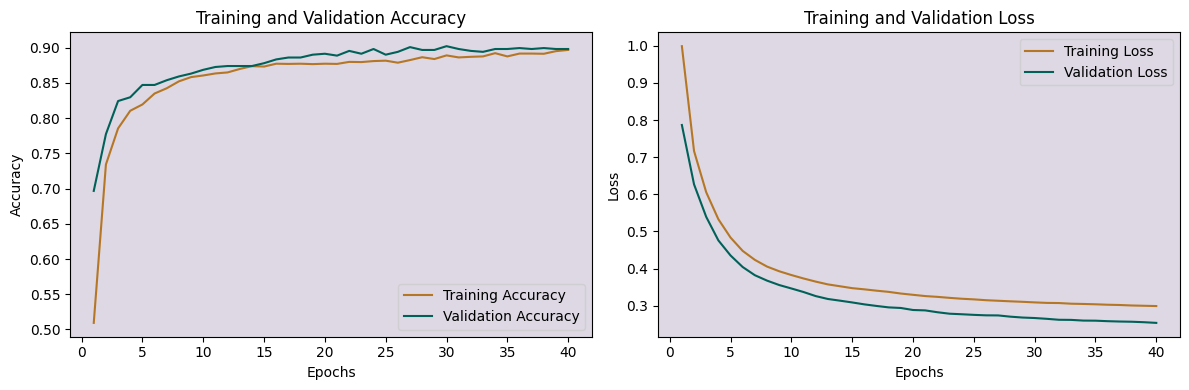

In [ ]:
acc_and_loss_visualization(model_2_history, colors)

ROC-кривые для каждого класса.

24/24 [==============================] - 0s 3ms/step


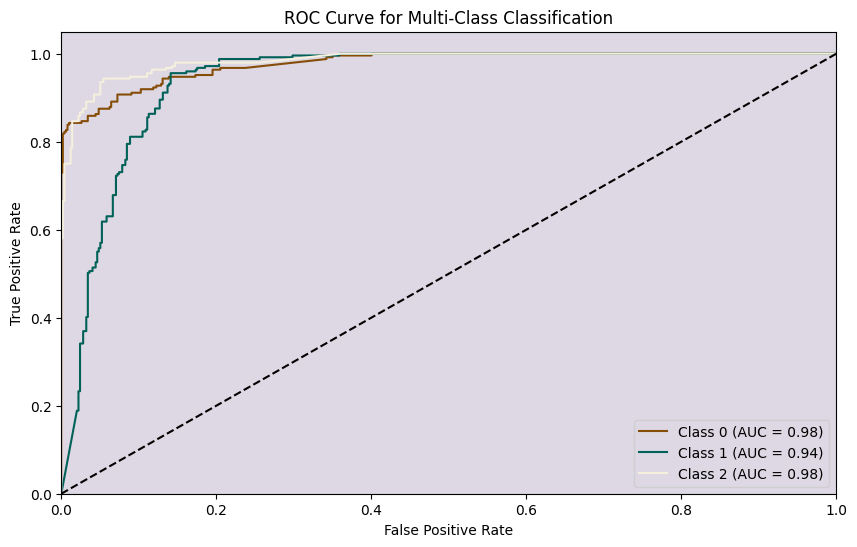

In [ ]:
plot_roc_curve_for_all_classes(model_2, X_test, y_test, colors)

Круговые диаграммы для классов.

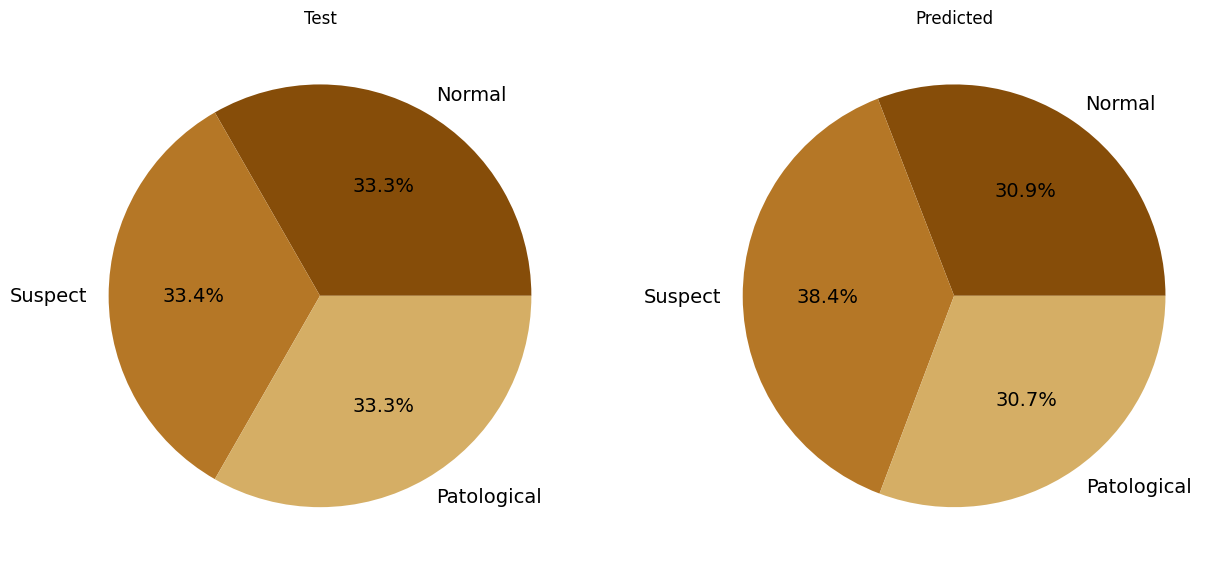

In [ ]:
test_and_pred_classes_count_pie(model_2, X_test, y_test)

Матрица спутанности.

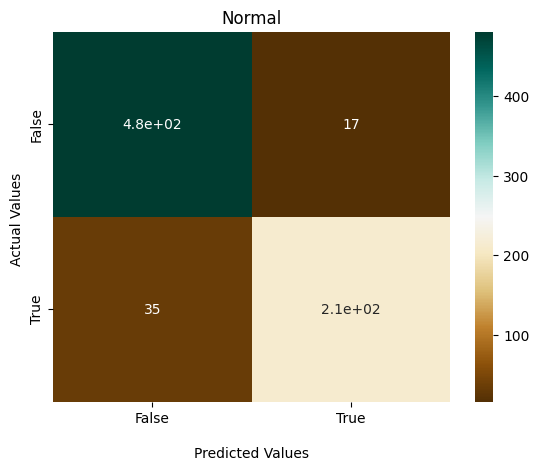

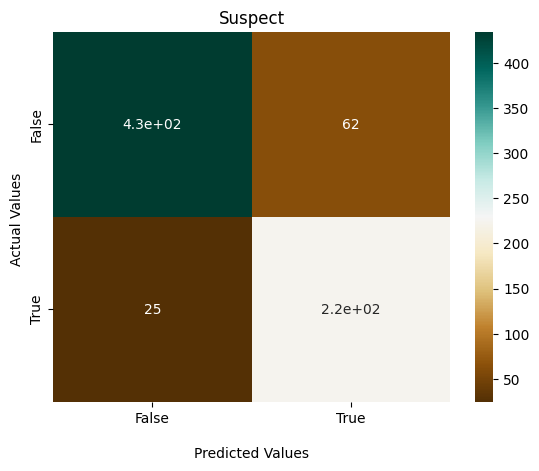

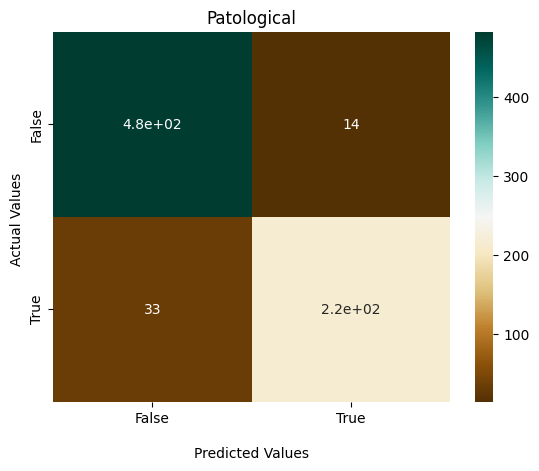

In [ ]:
confusion_matrix(model_2, X_test, y_test, palette)

##Модель №3

Возьмем за основу третьей модели модель №1 и изменим функцию активации выходного слоя на сигмоиду.

Если задача подразумевает собой классификацию, при которой метки являются взаимоисключающими, необходимо использовать softmax. softmax выдаст распределение вероятностей, что означает, что все выходные значения будут в сумме равны 1.

Если входные данные задачи классификации содержат несколько меток для входных данных, то есть классы не являются взаимоисключающими, можно использовать сигмоиду в качестве функции активации. В первом случае вы должны выбрать выходную запись с максимальным значением в качестве выходных данных. В этом случае выход каждого нейрона будет в диапазоне от 0 до 1. Затем можно взять максимальное значение и присвоить объекту класс, соответствующий этому самому значению.



In [ ]:
model_3 = Sequential()

model_3.add(tf.keras.layers.Dense(64, activation='relu'))
model_3.add(tf.keras.layers.Dense(32, activation='relu'))
model_3.add(tf.keras.layers.Dense(total_number_of_classes, activation = 'sigmoid'))

###Настройка параметров обучения

Остальные параметры обучения оставим такими же, как в прошлой модели.

In [ ]:
model_3.compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = [
      metrics.CategoricalAccuracy(),
      metrics.AUC(),
      metrics.Precision(),
      metrics.Recall()
    ],
  weighted_metrics = ['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 10,
  mode = 'max',
  verbose = 1
)

checkpoint_filepath_3 = path + 'task2/' + 'MC№3.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_3,
  monitor = 'val_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint
  ]

###Обучение модели

Обучим модель на 90 эпохах.

In [ ]:
model_3_history = model_3.fit(
  X_train,
  y_train,
  batch_size=10,
  validation_data=(X_val,y_val),
  callbacks=callbacks_list,
  epochs=90
)

Epoch 1/90
346/348 [============================>.] - ETA: 0s - loss: 0.5053 - categorical_accuracy: 0.8035 - auc_2: 0.9197 - precision_2: 0.7192 - recall_2: 0.8543 - accuracy: 0.8035
Epoch 1: val_accuracy improved from -inf to 0.89128, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task2/MC№3.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


348/348 [==============================] - 5s 8ms/step - loss: 0.5040 - categorical_accuracy: 0.8043 - auc_2: 0.9201 - precision_2: 0.7194 - recall_2: 0.8550 - accuracy: 0.8043 - val_loss: 0.2837 - val_categorical_accuracy: 0.8913 - val_auc_2: 0.9694 - val_precision_2: 0.7707 - val_recall_2: 0.9517 - val_accuracy: 0.8913
Epoch 2/90
338/348 [============================>.] - ETA: 0s - loss: 0.2909 - categorical_accuracy: 0.8870 - auc_2: 0.9677 - precision_2: 0.7467 - recall_2: 0.9515 - accuracy: 0.8870
Epoch 2: val_accuracy improved from 0.89128 to 0.91946, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task2/MC№3.hdf5
348/348 [==============================] - 1s 4ms/step - loss: 0.2919 - categorical_accuracy: 0.8872 - auc_2: 0.9673 - precision_2: 0.7448 - recall_2: 0.9514 - accuracy: 0.8872 - val_loss: 0.2255 - val_categorical_accuracy: 0.9195 - val_auc_2: 0.9779 - val_precision_2: 0.7818 - val_recall_2: 0.9664 - val_accuracy: 0.9195
Epoc

###Оценка модели

Оценим модель. Выведем метрики, графики процесса обучения и диаграммы для классов.

In [ ]:
print_scores(model_3, X_test, y_test)

Accuracy:  0.9677852392196655
AUC:  0.9851945042610168
Precision:  0.8046103119850159
Recall:  0.9838926196098328
Weighted Accuracy:  0.9677852392196655

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       248
           1       0.95      0.95      0.95       249
           2       0.97      1.00      0.99       248

    accuracy                           0.97       745
   macro avg       0.97      0.97      0.97       745
weighted avg       0.97      0.97      0.97       745



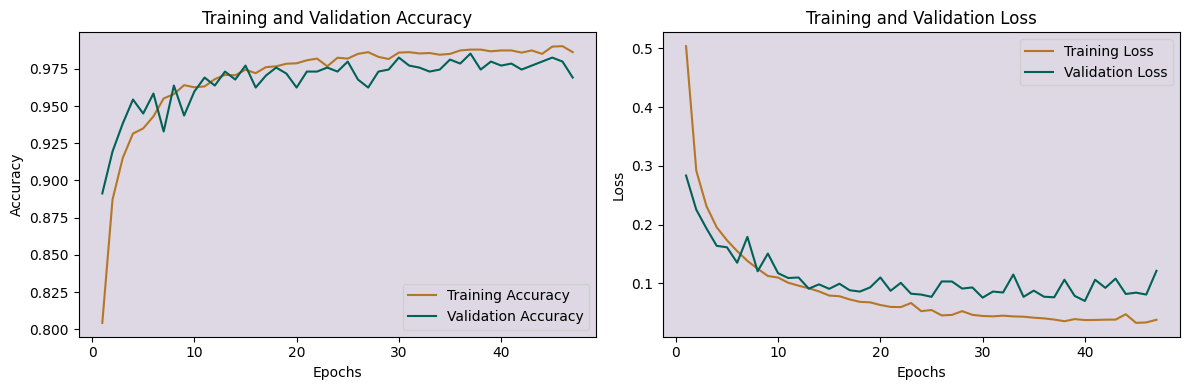

In [ ]:
acc_and_loss_visualization(model_3_history, colors)

24/24 [==============================] - 0s 2ms/step


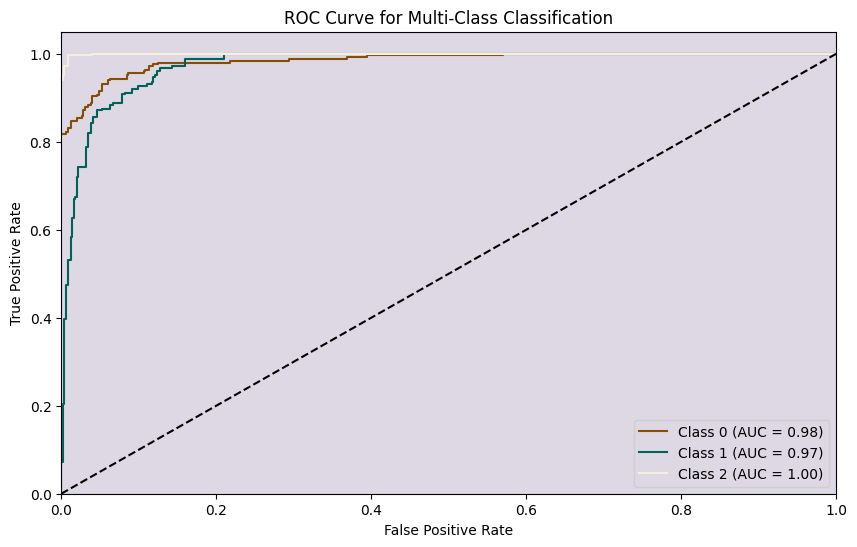

In [ ]:
plot_roc_curve_for_all_classes(model_3, X_test, y_test, colors)

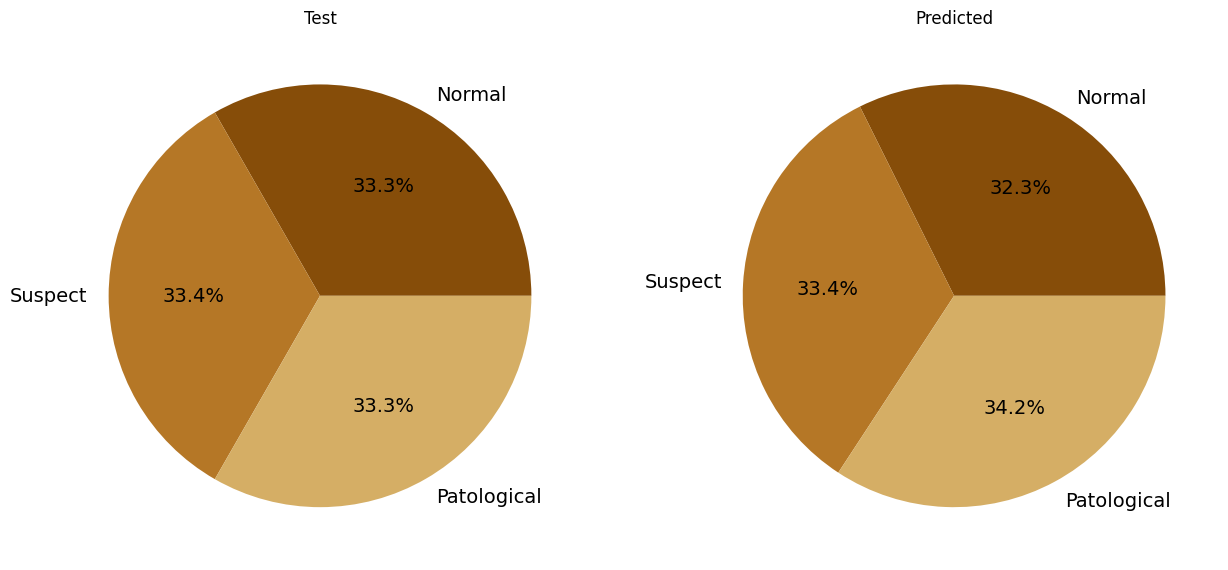

In [ ]:
test_and_pred_classes_count_pie(model_3, X_test, y_test)

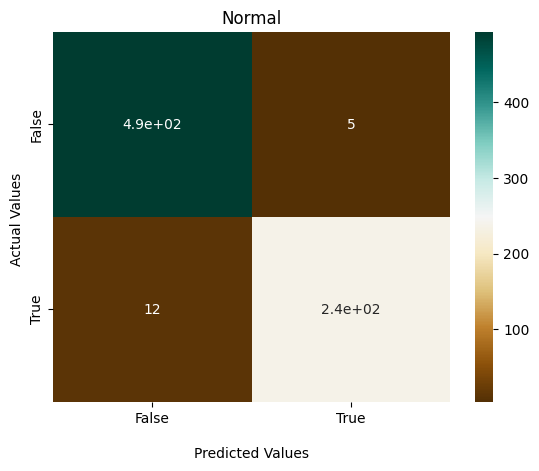

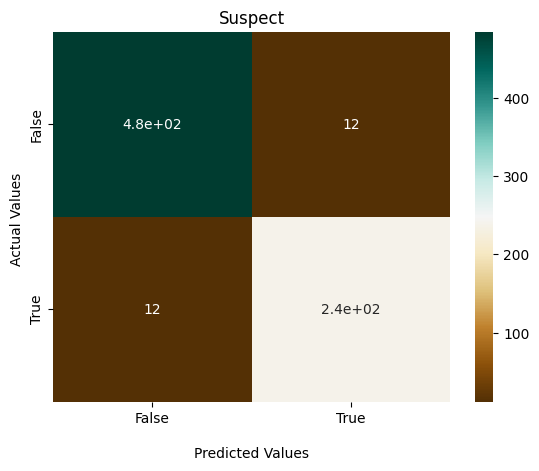

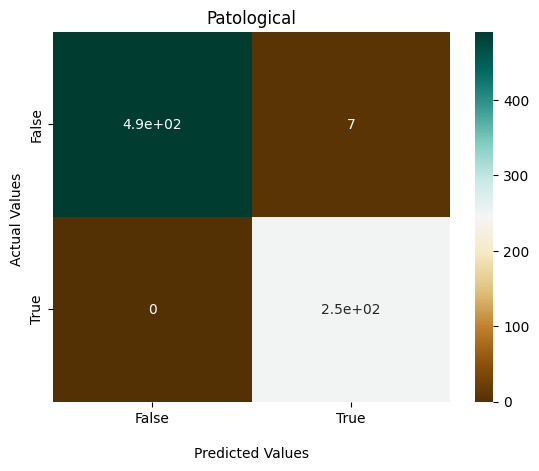

In [ ]:
confusion_matrix(model_3, X_test, y_test, palette)

##Модель №4

Построим модель, состоящую из четырех полносвязных слоев:

1) 128 нейронов, relu

2) 64 нейрона, selu

3) 32 нейрона, relu

4) 3 нейрона, softmax

In [ ]:
model_4 = Sequential()

model_4.add(tf.keras.layers.Dense(128, activation='relu'))
model_4.add(tf.keras.layers.Dense(64, activation='selu'))
model_4.add(tf.keras.layers.Dense(32, activation='relu'))
model_4.add(tf.keras.layers.Dense(total_number_of_classes, activation = 'softmax'))

###Настройка параметров обучения

В качестве оптимизатора выберем sgd.

In [ ]:
model_4.compile(
  optimizer = "sgd",
  loss = "categorical_crossentropy",
  metrics = [
      metrics.CategoricalAccuracy(),
      metrics.AUC(),
      metrics.Precision(),
      metrics.Recall()
    ],
  weighted_metrics = ['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 10,
  mode = 'max',
  verbose = 1
)

checkpoint_filepath_4 = path + 'task2/' + 'MC№4.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_4,
  monitor = 'val_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint
  ]

###Обучение модели

Запустим обучение модели на 90 эпохах.

In [ ]:
model_4_history = model_4.fit(
  X_train,
  y_train,
  batch_size=10,
  validation_data=(X_val,y_val),
  callbacks=callbacks_list,
  epochs=90
)

Epoch 1/90
339/348 [============================>.] - ETA: 0s - loss: 0.5602 - categorical_accuracy: 0.8053 - auc_3: 0.9298 - precision_3: 0.8591 - recall_3: 0.6764 - accuracy: 0.8053
Epoch 1: val_accuracy improved from -inf to 0.87919, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task2/MC№4.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


348/348 [==============================] - 4s 7ms/step - loss: 0.5541 - categorical_accuracy: 0.8075 - auc_3: 0.9314 - precision_3: 0.8608 - recall_3: 0.6814 - accuracy: 0.8075 - val_loss: 0.3467 - val_categorical_accuracy: 0.8792 - val_auc_3: 0.9711 - val_precision_3: 0.8936 - val_recall_3: 0.8456 - val_accuracy: 0.8792
Epoch 2/90
343/348 [============================>.] - ETA: 0s - loss: 0.3438 - categorical_accuracy: 0.8746 - auc_3: 0.9692 - precision_3: 0.8882 - recall_3: 0.8545 - accuracy: 0.8746
Epoch 2: val_accuracy improved from 0.87919 to 0.89396, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task2/MC№4.hdf5
348/348 [==============================] - 1s 4ms/step - loss: 0.3415 - categorical_accuracy: 0.8760 - auc_3: 0.9697 - precision_3: 0.8894 - recall_3: 0.8561 - accuracy: 0.8760 - val_loss: 0.2769 - val_categorical_accuracy: 0.8940 - val_auc_3: 0.9796 - val_precision_3: 0.9015 - val_recall_3: 0.8846 - val_accuracy: 0.8940
Epoc

###Оценка модели

Оценим модель.

In [ ]:
print_scores(model_4, X_test, y_test)

Accuracy:  0.9583892822265625
AUC:  0.9938263893127441
Precision:  0.9583892822265625
Recall:  0.9583892822265625
Weighted Accuracy:  0.9583892822265625

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       248
           1       0.89      0.99      0.94       249
           2       1.00      0.96      0.98       248

    accuracy                           0.96       745
   macro avg       0.96      0.96      0.96       745
weighted avg       0.96      0.96      0.96       745



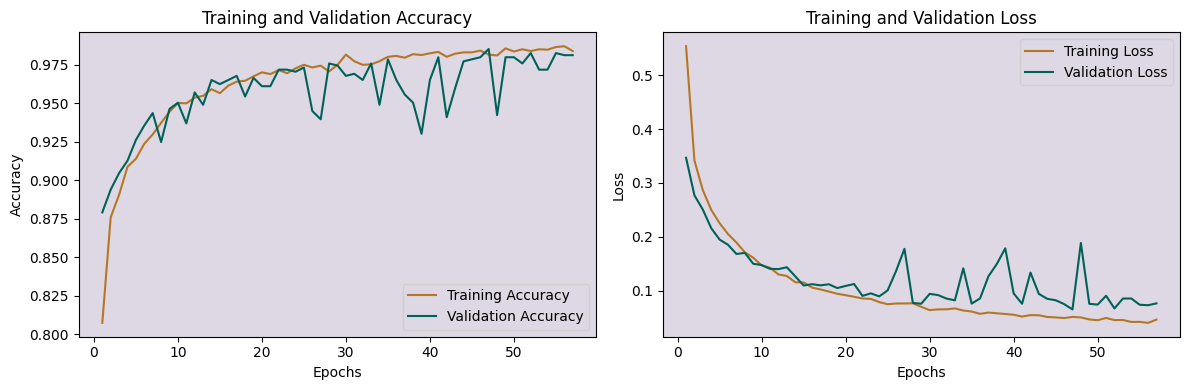

In [ ]:
acc_and_loss_visualization(model_4_history, colors)

24/24 [==============================] - 0s 2ms/step


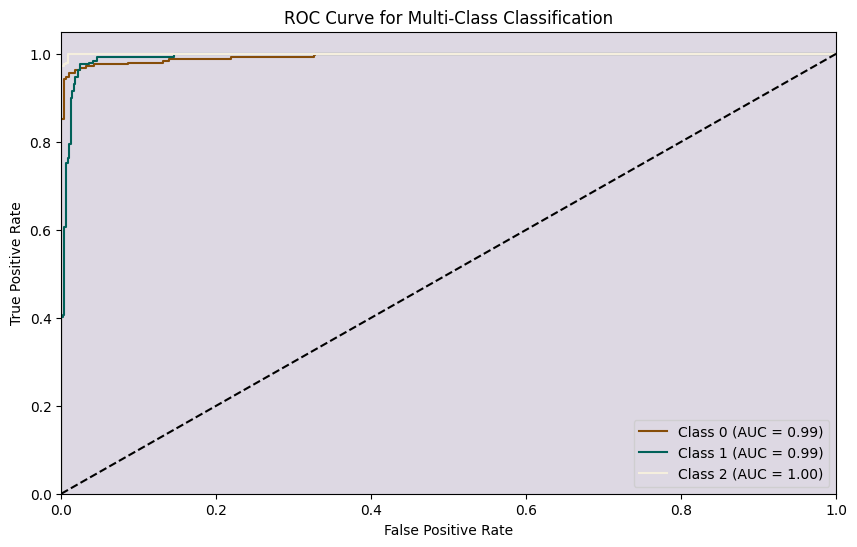

In [ ]:
plot_roc_curve_for_all_classes(model_4, X_test, y_test, colors)

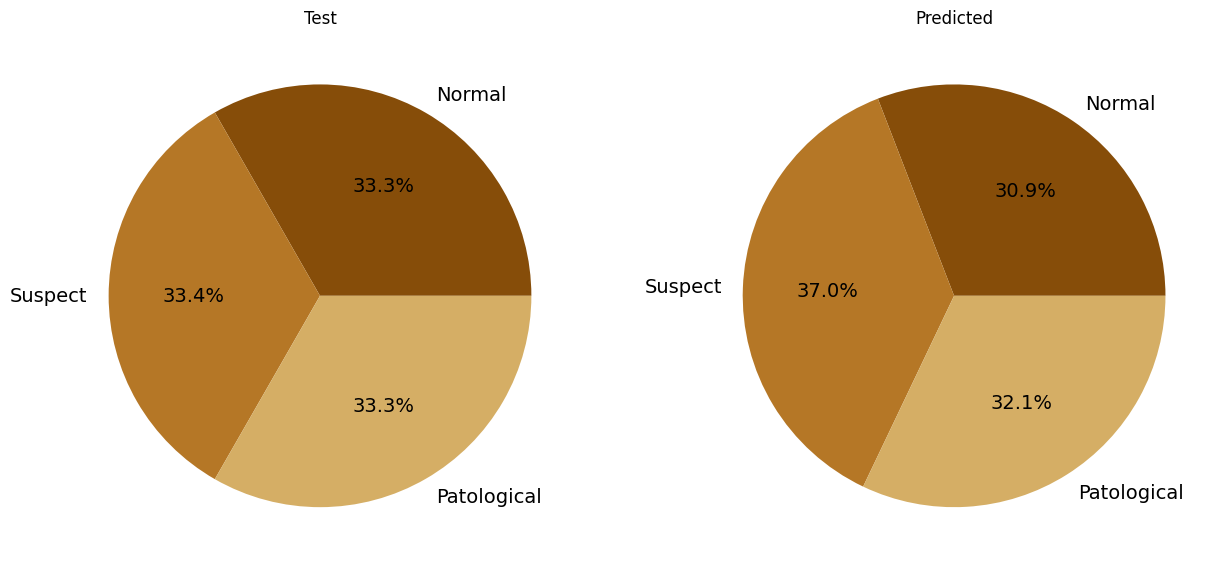

In [ ]:
test_and_pred_classes_count_pie(model_4, X_test, y_test)

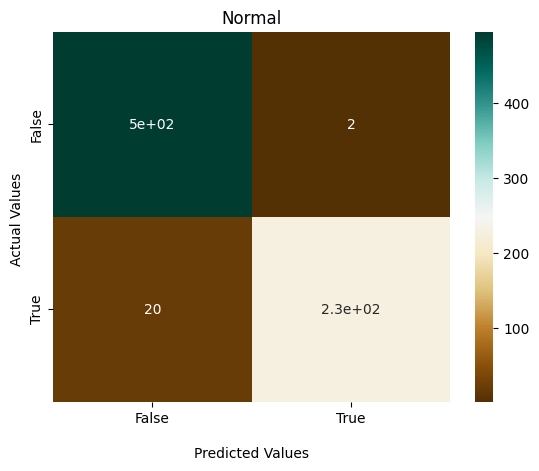

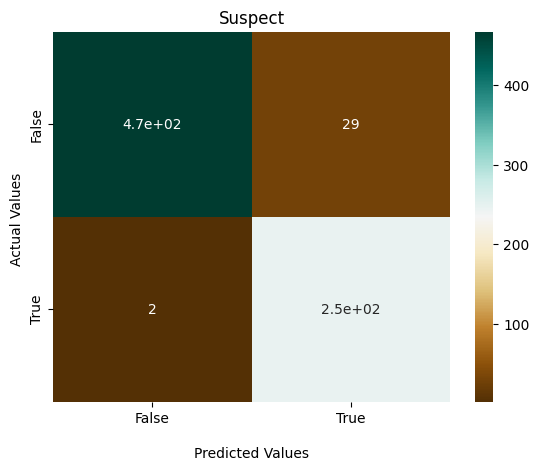

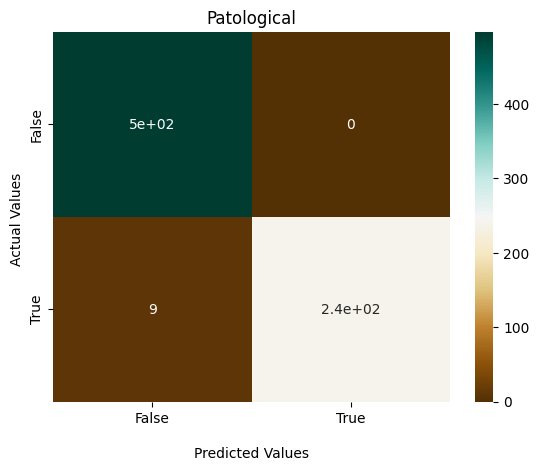

In [ ]:
confusion_matrix(model_4, X_test, y_test, palette)

#Выводы

По совокупности оценок лучший результат продемонстрировала модель №1. Модель с меньшим количеством слоев и нейронов является недообученной, модель с большим количеством слоев и нейронов быстрее переобучается. Использование функции активации sigmoid, как и ожидалось, несколько ухудшает итоговые характеристики модели.